#  Implementation of Adagrad Optimizer on Fashion MNIST model

In [1]:
from fashionmnist_model import FMM
import tensorflow as tf
import ray
from ray import tune, train
from sklearn.model_selection import KFold


In [2]:
# Load and preprocess the data
X_train, y_train, X_test, y_test = FMM.load_data()

In [3]:
# Reshape the data
X_train, X_test = FMM.reshape_data(X_train, X_test)

In [4]:
optimizer = tf.keras.optimizers.Adagrad()
model = FMM.get_model()
print(f"Training with {optimizer.__class__.__name__} optimizer...")
history = FMM.compile_and_train(
    model, X_train, y_train, optimizer
)

Training with model model_v1 ...
Training with Adagrad optimizer...
Epoch 1/30


2024-02-23 22:23:59.232874: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


750/750 [==============================] - 1s 1ms/step - loss: 1.5015 - accuracy: 0.5722 - val_loss: 1.0134 - val_accuracy: 0.7030
Epoch 2/30
750/750 [==============================] - 1s 1ms/step - loss: 0.8810 - accuracy: 0.7227 - val_loss: 0.7788 - val_accuracy: 0.7527
Epoch 3/30
750/750 [==============================] - 1s 1ms/step - loss: 0.7378 - accuracy: 0.7624 - val_loss: 0.6937 - val_accuracy: 0.7782
Epoch 4/30
750/750 [==============================] - 1s 1ms/step - loss: 0.6702 - accuracy: 0.7842 - val_loss: 0.6420 - val_accuracy: 0.7918
Epoch 5/30
750/750 [==============================] - 1s 1ms/step - loss: 0.6281 - accuracy: 0.7969 - val_loss: 0.6086 - val_accuracy: 0.8009
Epoch 6/30
750/750 [==============================] - 1s 1ms/step - loss: 0.5984 - accuracy: 0.8055 - val_loss: 0.5848 - val_accuracy: 0.8092
Epoch 7/30
750/750 [==============================] - 1s 1ms/step - loss: 0.5750 - accuracy: 0.8125 - val_loss: 0.5646 - val_accuracy: 0.8146
Epoch 8/30
750/75

313/313 - 0s - loss: 0.4669 - accuracy: 0.8394 - 134ms/epoch - 428us/step

Training accuracy : 0.851729154586792
Validation accuracy : 0.8481666445732117
Loss : 0.4669426679611206
Accuracy : 0.8393999934196472



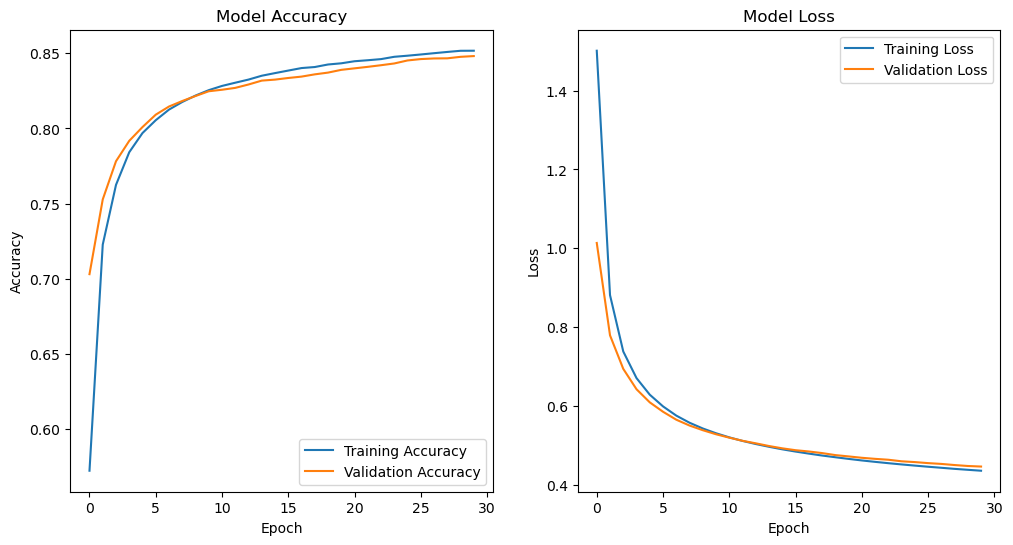

In [5]:
FMM.evaluate(model, X_test, y_test, history)
FMM.plot_history(history)

# Hyperparameter tunning

In [6]:
# Hyperparameter tunning

In [7]:
ray.init()

2024-02-23 22:24:24,993	INFO worker.py:1715 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 


Python version:,3.11.5
Ray version:,2.9.2
Dashboard:,http://127.0.0.1:8265


In [8]:
def train_model(config, kf):
    
    # Load and preprocess the data within the function
    X_train, y_train, X_test, y_test = FMM.load_data()
    X_train, X_test = FMM.reshape_data(X_train, X_test)
    
    # Extracts k-fold splits
    for train_index, val_index in kf.split(X_train):
        x_train_fold, x_val_fold = X_train[train_index], X_train[val_index]
        y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
        
        # Define and compile the model
        model = FMM.get_model()
        optimizer = tf.keras.optimizers.Adagrad(
            learning_rate=config["learning_rate"]
        )
        model.compile(optimizer=optimizer,
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])
        
        # Train the model
        history = model.fit(x_train_fold, y_train_fold,
                            validation_data=(x_val_fold, y_val_fold),
                            epochs=40, batch_size=64, verbose=0)
        
        # Evaluates the model
        loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
        
        # Reports results
        train.report({"accuracy": accuracy, "loss":loss, "learning_rate":config["learning_rate"]})


In [9]:
# Cell 5: Set up k-fold cross-validation
kf = KFold(n_splits=5, shuffle=True)


In [10]:
search_space = {
    "learning_rate": tune.grid_search([0.01, 0.001, 0.0001]),
    # "epsilon": tune.grid_search([1e-8, 1e-9, 1e-10]),
}

In [11]:
#Runs hyperparameter tuning with k-fold cross-validation
analysis = tune.run(
    lambda config: train_model(config, kf),
    config=search_space,
    metric="accuracy",
    mode="max",
)


2024-02-23 22:24:25,529	INFO tune.py:583 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


(<lambda> pid=76361) Training with model model_v1 ...


(<lambda> pid=76363) WARNING:absl:At this time, the v2.11+ optimizer `tf.keras.optimizers.Adagrad` runs slowly on M1/M2 Macs, please use the legacy Keras optimizer instead, located at `tf.keras.optimizers.legacy.Adagrad`.
(<lambda> pid=76363) WARNING:absl:There is a known slowdown when using v2.11+ Keras optimizers on M1/M2 Macs. Falling back to the legacy Keras optimizer, i.e., `tf.keras.optimizers.legacy.Adagrad`.
(<lambda> pid=76363) 2024-02-23 22:24:33.331260: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
(raylet) [2024-02-23 22:24:34,977 E 76347 1144400] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-02-23_22-24-22_940675_76329 is over 95% full, available space: 9776902144; capacity: 245107195904. Object creation will fail if spilling is required.
(<lambda> pid=76362) WARNING:absl:At this time, the v2.11+ optimizer `tf.keras.optimizers.Adagrad` runs slowly on M1/M2 Macs, please use the legacy Keras optimizer instead, locate

Trial name,accuracy,learning_rate,loss
lambda_35f03_00000,0.8801,0.01,0.333961
lambda_35f03_00001,0.8444,0.001,0.443617
lambda_35f03_00002,0.7554,0.0001,0.762991


(<lambda> pid=76361) Training with model model_v1 ... [repeated 3x across cluster]


(<lambda> pid=76361) WARNING:absl:At this time, the v2.11+ optimizer `tf.keras.optimizers.Adagrad` runs slowly on M1/M2 Macs, please use the legacy Keras optimizer instead, located at `tf.keras.optimizers.legacy.Adagrad`.
(<lambda> pid=76361) WARNING:absl:There is a known slowdown when using v2.11+ Keras optimizers on M1/M2 Macs. Falling back to the legacy Keras optimizer, i.e., `tf.keras.optimizers.legacy.Adagrad`.
(raylet) [2024-02-23 22:25:35,369 E 76347 1144400] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-02-23_22-24-22_940675_76329 is over 95% full, available space: 9782439936; capacity: 245107195904. Object creation will fail if spilling is required.
(<lambda> pid=76363) WARNING:absl:At this time, the v2.11+ optimizer `tf.keras.optimizers.Adagrad` runs slowly on M1/M2 Macs, please use the legacy Keras optimizer instead, located at `tf.keras.optimizers.legacy.Adagrad`. [repeated 2x across cluster]
(<lambda> pid=76363) WARNING:absl:There is a known slowdown when usin

(<lambda> pid=76361) Training with model model_v1 ... [repeated 3x across cluster]


(<lambda> pid=76361) WARNING:absl:At this time, the v2.11+ optimizer `tf.keras.optimizers.Adagrad` runs slowly on M1/M2 Macs, please use the legacy Keras optimizer instead, located at `tf.keras.optimizers.legacy.Adagrad`.
(<lambda> pid=76361) WARNING:absl:There is a known slowdown when using v2.11+ Keras optimizers on M1/M2 Macs. Falling back to the legacy Keras optimizer, i.e., `tf.keras.optimizers.legacy.Adagrad`.
(raylet) [2024-02-23 22:26:35,773 E 76347 1144400] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-02-23_22-24-22_940675_76329 is over 95% full, available space: 9745752064; capacity: 245107195904. Object creation will fail if spilling is required.
(<lambda> pid=76363) WARNING:absl:At this time, the v2.11+ optimizer `tf.keras.optimizers.Adagrad` runs slowly on M1/M2 Macs, please use the legacy Keras optimizer instead, located at `tf.keras.optimizers.legacy.Adagrad`. [repeated 2x across cluster]
(<lambda> pid=76363) WARNING:absl:There is a known slowdown when usin

(<lambda> pid=76361) Training with model model_v1 ... [repeated 3x across cluster]


(<lambda> pid=76361) WARNING:absl:At this time, the v2.11+ optimizer `tf.keras.optimizers.Adagrad` runs slowly on M1/M2 Macs, please use the legacy Keras optimizer instead, located at `tf.keras.optimizers.legacy.Adagrad`.
(<lambda> pid=76361) WARNING:absl:There is a known slowdown when using v2.11+ Keras optimizers on M1/M2 Macs. Falling back to the legacy Keras optimizer, i.e., `tf.keras.optimizers.legacy.Adagrad`.
(raylet) [2024-02-23 22:27:36,167 E 76347 1144400] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-02-23_22-24-22_940675_76329 is over 95% full, available space: 9736232960; capacity: 245107195904. Object creation will fail if spilling is required.
(<lambda> pid=76363) WARNING:absl:At this time, the v2.11+ optimizer `tf.keras.optimizers.Adagrad` runs slowly on M1/M2 Macs, please use the legacy Keras optimizer instead, located at `tf.keras.optimizers.legacy.Adagrad`. [repeated 2x across cluster]
(<lambda> pid=76363) WARNING:absl:There is a known slowdown when usin

(<lambda> pid=76361) Training with model model_v1 ... [repeated 3x across cluster]


(<lambda> pid=76361) WARNING:absl:At this time, the v2.11+ optimizer `tf.keras.optimizers.Adagrad` runs slowly on M1/M2 Macs, please use the legacy Keras optimizer instead, located at `tf.keras.optimizers.legacy.Adagrad`.
(<lambda> pid=76361) WARNING:absl:There is a known slowdown when using v2.11+ Keras optimizers on M1/M2 Macs. Falling back to the legacy Keras optimizer, i.e., `tf.keras.optimizers.legacy.Adagrad`.
(raylet) [2024-02-23 22:28:46,573 E 76347 1144400] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-02-23_22-24-22_940675_76329 is over 95% full, available space: 9735049216; capacity: 245107195904. Object creation will fail if spilling is required.
(<lambda> pid=76363) WARNING:absl:At this time, the v2.11+ optimizer `tf.keras.optimizers.Adagrad` runs slowly on M1/M2 Macs, please use the legacy Keras optimizer instead, located at `tf.keras.optimizers.legacy.Adagrad`. [repeated 2x across cluster]
(<lambda> pid=76363) WARNING:absl:There is a known slowdown when usin

In [12]:
ray.shutdown()

In [13]:
# FMM.plot_analysis_results(analysis, x_axis="learning_rate", y_axis="accuracy")

In [14]:
# Print the best hyperparameters and results
best_config = analysis.best_config
print("Best hyperparameters:", best_config)
print("Best accuracy:", analysis.best_result["accuracy"])

Best hyperparameters: {'learning_rate': 0.01}
Best accuracy: 0.8801000118255615


In [15]:
optimizer = tf.keras.optimizers.Adagrad(**best_config)
model = FMM.get_model()
print(f"Training with {optimizer.__class__.__name__} optimizer...")
history = FMM.compile_and_train(
    model, X_train, y_train, optimizer
)

Training with model model_v1 ...
Training with Adagrad optimizer...
Epoch 1/30
750/750 [==============================] - 1s 1ms/step - loss: 0.7033 - accuracy: 0.7675 - val_loss: 0.5464 - val_accuracy: 0.7970
Epoch 2/30
750/750 [==============================] - 1s 1ms/step - loss: 0.4810 - accuracy: 0.8334 - val_loss: 0.4602 - val_accuracy: 0.8367
Epoch 3/30
750/750 [==============================] - 1s 1ms/step - loss: 0.4366 - accuracy: 0.8489 - val_loss: 0.4253 - val_accuracy: 0.8475
Epoch 4/30
750/750 [==============================] - 1s 1ms/step - loss: 0.4117 - accuracy: 0.8570 - val_loss: 0.4254 - val_accuracy: 0.8500
Epoch 5/30
750/750 [==============================] - 1s 1ms/step - loss: 0.3927 - accuracy: 0.8628 - val_loss: 0.4049 - val_accuracy: 0.8550
Epoch 6/30
750/750 [==============================] - 1s 1ms/step - loss: 0.3778 - accuracy: 0.8675 - val_loss: 0.3920 - val_accuracy: 0.8608
Epoch 7/30
750/750 [==============================] - 1s 1ms/step - loss: 0.3672

313/313 - 0s - loss: 0.3377 - accuracy: 0.8797 - 151ms/epoch - 484us/step

Training accuracy : 0.9123541712760925
Validation accuracy : 0.8849166631698608
Loss : 0.3377070426940918
Accuracy : 0.8797000050544739



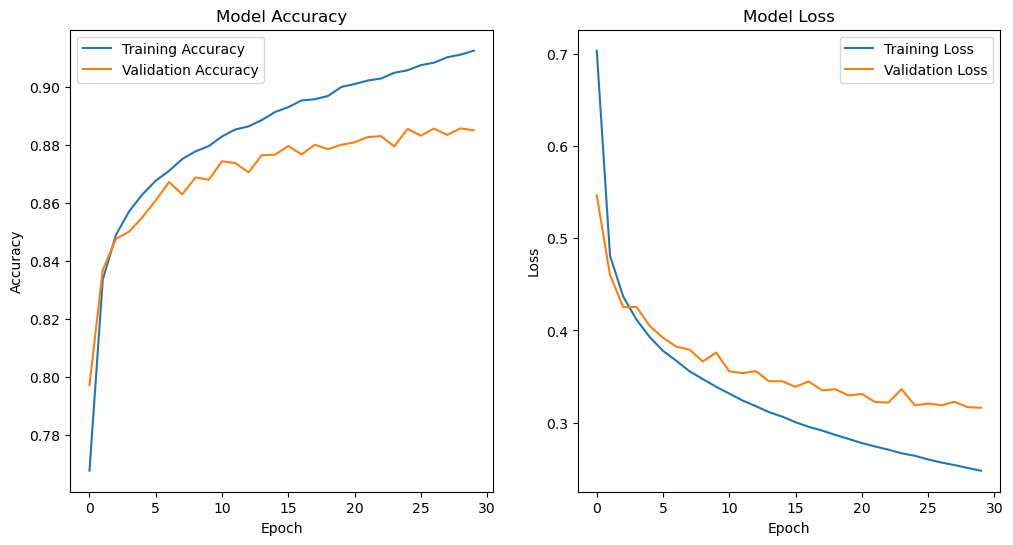

In [16]:
FMM.evaluate(model, X_test, y_test, history)
FMM.plot_history(history)